## "Classical" Statistics analysis

Here we investigate a more traditional probabilistic approach: find the best-fitting distribution for the data and use a combination of z-scores / cumulative distribution functions / etc. to evaluate the probability of an event happening in the next observation or set of observations.

For example, if the energy data fits a normal distribution, then we might say "an earthquake with magnitude 5 energy is 3 standard deviations away from the mean, and only has a 0.15% chance of occurring in any given event."

However, as we see below, the **lognormal** distribution fits best. And specifically, this is a lognormal of the *log-transformed* energy, meaning the \$log(log(energy))\$ function corresponds to a normal distribution.

In [454]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from scipy.stats import norm
import scipy.stats as st

import warnings
warnings.filterwarnings("ignore")

In [455]:
df1 = pd.read_csv('LA_1970_1978')
df2 = pd.read_csv('LA_1979_1988')
df3 = pd.read_csv('LA_1989_1999')
df4 = pd.read_csv('LA_2000_2023')

main_df = pd.concat((df1, df2, df3, df4)).reset_index(drop=True)

#converting object to a datetime object
main_df['time'] = pd.to_datetime(main_df['time'])

#creating the energy feature from the magnitude
main_df['energy'] = 10 ** (4.4 + 1.5 * main_df['magnitude'])

main_df.head(2)

,id,time,location,latitude,longitude,depth,magnitude,alert,url,eventtype,significance,energy
0,ci3324955,1970-01-02 10:45:20.570,"24km S of Santa Barbara, CA",34.2060,-119.695667,6.0,3.14,NaN,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,152,1.288250e+09
1,ci3324959,1970-01-03 19:48:40.840,"6km NE of Banning, CA",33.9605,-116.830500,6.0,3.16,NaN,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,154,1.380384e+09


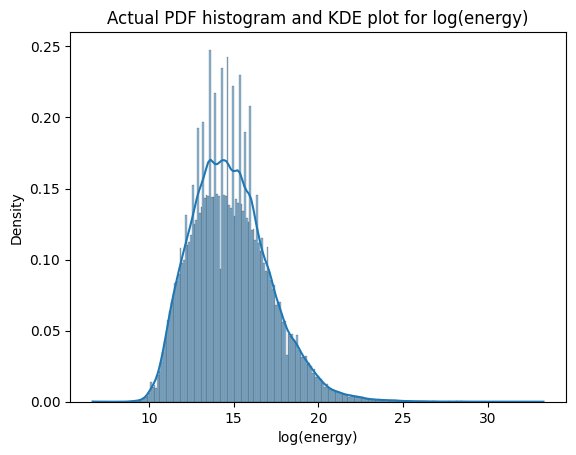

In [456]:
sns.histplot(np.log(main_df['energy']), kde=True, stat = 'density')
plt.xlabel("log(energy)")
plt.title("Actual PDF histogram and KDE plot for log(energy)")
plt.show();

#### Lognormal Distribution

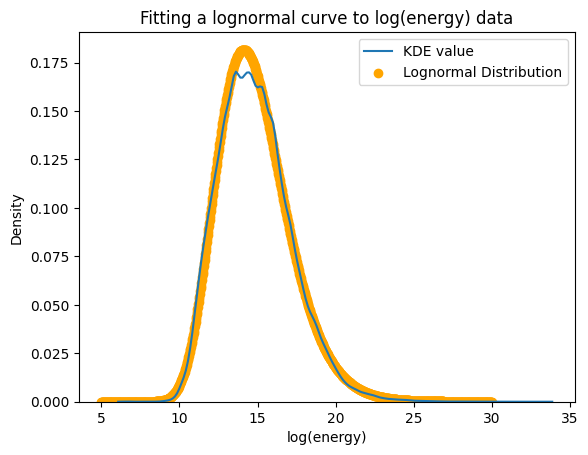

In [457]:
#getting the shape arguments for the distribution
arg1, arg2, arg3 = stats.lognorm.fit(np.log(main_df['energy'].dropna()))

x = np.linspace(5,30,1000)
y = stats.lognorm.pdf(x, arg1, arg2, arg3)

ax1 = sns.kdeplot(np.log(main_df['energy']))
ax2 = plt.scatter(x,y, color='orange')
ax1.legend(['KDE value', 'Lognormal Distribution',])
plt.xlabel("log(energy)")
plt.title('Fitting a lognormal curve to log(energy) data')
plt.show()

Note that when you include the histogram, there are 'hairs' sticking out of the top of the curve. I believe these are due to rounding errors and/or discretizing in the original data. I think the KDE value does a good job smoothing the data into something closer to reality, so we'll continue to use that in lieu of the histogram. But it *is* a detail to be mindful of in this analysis.

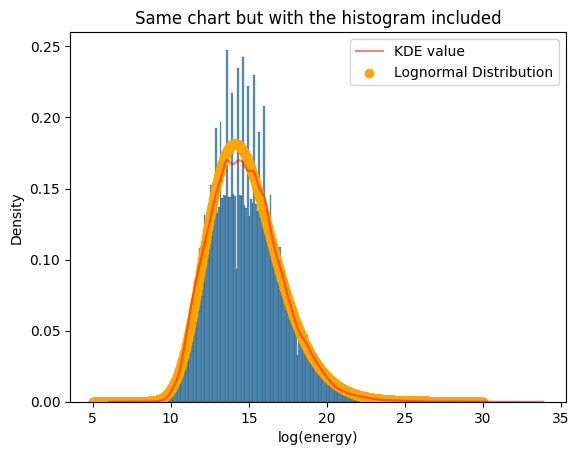

In [458]:
#getting the shape arguments for the distribution
arg1, arg2, arg3 = stats.lognorm.fit(np.log(main_df['energy'].dropna()))

x = np.linspace(5,30,1000)
y = stats.lognorm.pdf(x, arg1, arg2, arg3)

ax1 = sns.kdeplot(np.log(main_df['energy']), color='red', alpha=0.5)
ax3 = sns.histplot(np.log(main_df['energy']), stat='density')
ax2 = plt.scatter(x,y, color='orange')
ax1.legend(['KDE value', 'Lognormal Distribution',])
plt.xlabel("log(energy)")
plt.title('Same chart but with the histogram included')
plt.show()

#### Other attempts: Normal Distribution

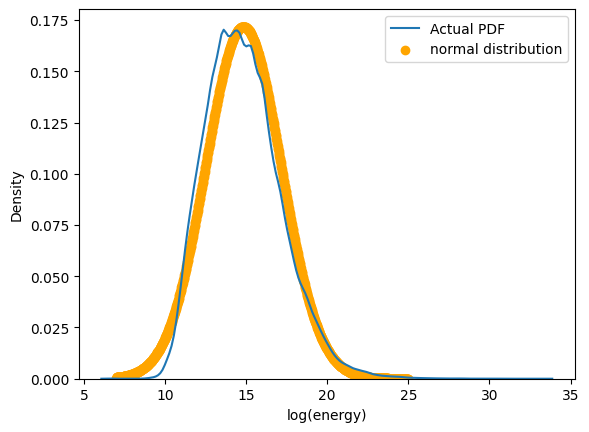

In [459]:
log_energy_mean = np.log(main_df['energy']).mean()
log_energy_std = np.log(main_df['energy']).std()

#getting the shape arguments for the distribution
x = np.linspace(7,25,1000)
y = norm.pdf(x, log_energy_mean, log_energy_std)

ax1 = sns.kdeplot(np.log(main_df['energy']))
ax2 = plt.scatter(x,y, color='orange')
ax1.legend(['Actual PDF', 'normal distribution',])
plt.xlabel("log(energy)")
plt.show()

#### Other attempts: Cauchy Distribution

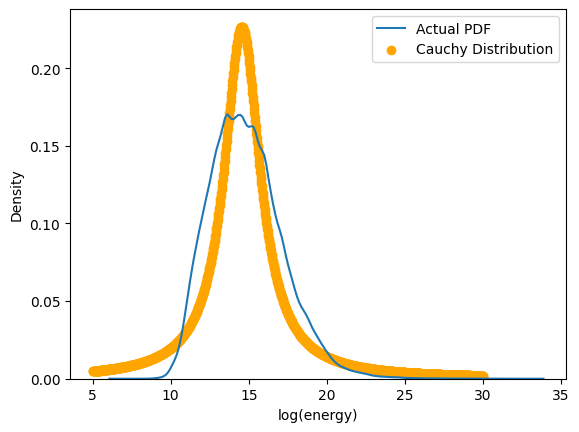

In [460]:
#getting the shape arguments for the distribution
arg1, arg2 = stats.cauchy.fit(np.log(main_df['energy'].dropna()))

x = np.linspace(5,30,1000)
y = stats.cauchy.pdf(x, arg1, arg2)

ax1 = sns.kdeplot(np.log(main_df['energy']))
ax2 = plt.scatter(x,y, color='orange')
ax1.legend(['Actual PDF', 'Cauchy Distribution',])
plt.xlabel("log(energy)")
plt.show()

### How many earthquakes per year does this predict?

First we're going to determine how many events happened at each level of magnitude in the dataset. This will help us determine, on average, how many earthquakes happen per day, per month, per year, etc.

We also calculate the mean and standard deviation of the transformed \$log(log(energy))\$ sample. We'll treat this as a normal distribution, calculate the appropriate z-score for each earthquake magnitude, and this will give us a probability that any given earthquake event will be magnitude 2, 3, 4, ...

Using this probability, and using the knowledge of how many earthquakes happen every day / year, we can calculate the probability of a rare large earthquake event over the next 10 years.

In [461]:
#setting energy benchmarks for each magnitude
mag1 = 10**(4.4+1.5*1)
mag2 = 10**(4.4+1.5*2)
mag3 = 10**(4.4+1.5*3)
mag4 = 10**(4.4+1.5*4)
mag5 = 10**(4.4+1.5*5)
mag6 = 10**(4.4+1.5*6)
mag7 = 10**(4.4+1.5*7)

In [462]:
#applying the log transformation
log_mag1 = np.log(mag1)
log_mag2 = np.log(mag2)
log_mag3 = np.log(mag3)
log_mag4 = np.log(mag4)
log_mag5 = np.log(mag5)
log_mag6 = np.log(mag6)
log_mag7 = np.log(mag7)

In [463]:
logmag_list = [log_mag1,log_mag2,log_mag3,log_mag4,log_mag5,log_mag6,log_mag7]
num_iter = 1

#note these numbers are inclusive / cumulative
# e.g. every magnitude 3 event is also a magnitude 2 event and a magnitude 1 event
for magnitude in logmag_list:
    print(f"Magnitude {num_iter} events in the dataset: \
    {len(main_df[np.log(main_df['energy']) > magnitude])}")
    num_iter +=1

Magnitude 1 events in the dataset:     142820
Magnitude 2 events in the dataset:     34386
Magnitude 3 events in the dataset:     3407
Magnitude 4 events in the dataset:     361
Magnitude 5 events in the dataset:     42
Magnitude 6 events in the dataset:     3
Magnitude 7 events in the dataset:     0


In [464]:
sample_mean = np.log(np.log(main_df['energy'])).mean()
sample_std = np.log(np.log(main_df['energy'])).std()

print(f"Transformed mean:  {np.round(sample_mean, 4)}")
print(f"Transformed stdev: {np.round(sample_std,4)}")

Transformed mean:  2.685
Transformed stdev: 0.1537


### Z-score to find probability

Because the $\log(\log(energy))$ follows a normal distribution, we'll use the standard z-score and $\mu$ and $\sigma$ to calculate the rarity of large events happening--that is to say, rare events being several standard deviations away from the mean.

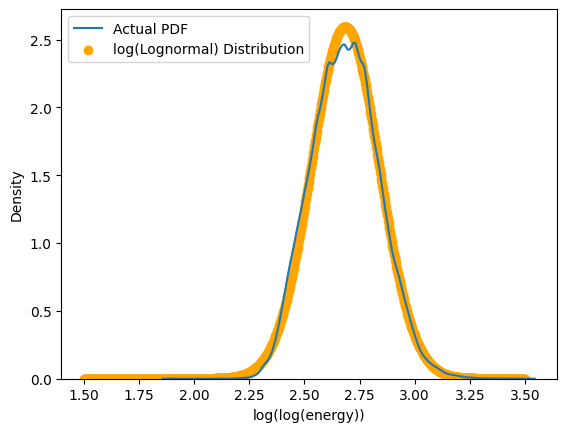

In [465]:
x = np.linspace(1.5,3.5,1000)
y = norm.pdf(x, sample_mean, sample_std)

ax1 = sns.kdeplot(np.log(np.log(main_df['energy'])))
ax2 = plt.scatter(x,y, color='orange')
ax1.legend(['Actual PDF', 'log(Lognormal) Distribution',])
plt.xlabel("log(log(energy))")
plt.show()

In [466]:
logmag_list = [log_mag1,log_mag2,log_mag3,log_mag4,log_mag5,log_mag6,log_mag7]
sum_num = 1

for i in logmag_list:
    #calculate z-score
    z = (np.log(i) - sample_mean) / sample_std
    print(f"Magnitude {sum_num} z-score: {np.round(z,3)}")
    print(f"Probability: {np.round((1 - st.norm.cdf(z))*100,9)}%\n")
    sum_num += 1

Magnitude 1 z-score: -0.494
Probability: 68.942754661%

Magnitude 2 z-score: 0.979
Probability: 16.370433338%

Magnitude 3 z-score: 2.18
Probability: 1.462897748%

Magnitude 4 z-score: 3.193
Probability: 0.070356298%

Magnitude 5 z-score: 4.07
Probability: 0.002354408%

Magnitude 6 z-score: 4.842
Probability: 6.4307e-05%

Magnitude 7 z-score: 5.532
Probability: 1.582e-06%



#### Use the z-score / probability information to predict events per year

This involves determining:
* How many events are recorded per year
* The probability that any one event is of magnitude 2, 3, 4, ...

In [467]:
number_of_days = (main_df['time'].max() - main_df['time'].min()).days
events_per_day = len(main_df) / number_of_days
print(f"Average of {np.round(events_per_day,2)} earthquakes per day (all magnitudes)")

Average of 11.33 earthquakes per day (all magnitudes)


In [468]:
for i in range(0,7):
    #how many events are above the specified energy magnitude
    quakes = len(main_df[np.log(main_df['energy']) > logmag_list[i]])

    #annualize the number
    annual_quakes = (quakes / number_of_days) * 365.25
    print(f"Actual magnitude {i+1} number of events per year: {np.round(annual_quakes,4)}")

Actual magnitude 1 number of events per year: 2659.5801
Actual magnitude 2 number of events per year: 640.3327
Actual magnitude 3 number of events per year: 63.4448
Actual magnitude 4 number of events per year: 6.7225
Actual magnitude 5 number of events per year: 0.7821
Actual magnitude 6 number of events per year: 0.0559
Actual magnitude 7 number of events per year: 0.0


In [469]:
num_iter = 1
for i in logmag_list:
    
    #find percentage from z-score, multiply by (number of events per day) and x 365
    events_per_year = (1 - st.norm.cdf((np.log(i) - sample_mean) / sample_std)) \
    * 365 * events_per_day
    print(f"Predicted magnitude {num_iter} events per year: {np.round(events_per_year,5)}")

    #bring the actual information in
    quakes = len(main_df[np.log(main_df['energy']) > i])
    annual_quakes = (quakes / number_of_days) * 365.25
    print(f"Actual magnitude {num_iter} events per year:    {np.round(annual_quakes,5)}\n")
    
    num_iter +=1

Predicted magnitude 1 events per year: 2851.82931
Actual magnitude 1 events per year:    2659.58015

Predicted magnitude 2 events per year: 677.16589
Actual magnitude 2 events per year:    640.33275

Predicted magnitude 3 events per year: 60.51303
Actual magnitude 3 events per year:    63.44482

Predicted magnitude 4 events per year: 2.9103
Actual magnitude 4 events per year:    6.72251

Predicted magnitude 5 events per year: 0.09739
Actual magnitude 5 events per year:    0.78212

Predicted magnitude 6 events per year: 0.00266
Actual magnitude 6 events per year:    0.05587

Predicted magnitude 7 events per year: 7e-05
Actual magnitude 7 events per year:    0.0



### Results

The classical statistics approach is a very good first approximation for the region. However, it tends to slightly over-predict the number of smaller earthquakes, and slightly under-predict the frequency of larger earthquakes.



## Applying a Similar Analysis to Specific Locations

This is tough because locations can have so much variability, and it's not clear whether an earthquake 50km away (for example) should count just as much as an earthquake 2km away or 200km away. We've chosen to take the *distance-weighted energy contributions* and sum them by month. Therefore we're not looking at single earthquake events, but rather seismic energy contributions by month.

The following DataFrame includes the distance-weighted contributions of regional earthquakes to a 21x21 lattice grid covering approximately 40,000 square kilometers, centered around Los Angeles.

In [470]:
updated_df = pd.read_csv('LA_energy_1970_2023.csv')

transposed_df = updated_df.drop(columns=['Latitude','Longitude']).T
transposed_df.index = pd.to_datetime(transposed_df.index, format='%Y_%m')

transposed_df.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440
1970-01-01,321067.119801,321135.048331,321124.857167,321042.681773,320896.868751,320696.998421,320453.023487,320174.622771,319870.785259,319549.580501,319218.049104,318882.156407,318546.777063,318215.701293,317891.665816,317576.413844,317270.783954,316974.822567,316687.911972,316408.905932,316136.267021,322751.808165,322812.718625,322772.258996,322640.581051,322430.753426,322157.056346,321833.624469,321473.578388,321088.606697,320688.851553,320282.932453,319877.993745,319479.734025,319092.428576,318718.973683,318360.972822,318018.867006,317692.098174,317379.289507,317078.428393,316787.043178,324789.837918,324833.331842,324742.267207,324534.091541,324229.883626,323851.307609,323418.490685,322948.987495,322457.615259,321956.744291,321456.654454,320965.747286,320490.599746,320035.954790,319604.749092,319198.226809,318816.135296,318456.970766,318118.238409,317796.700703,317488.600385,327314.539756,327320.017296,327142.321384,326812.753921,326366.423185,325836.725380,325252.119867,324635.298388,324004.026228,323372.547152,322752.650585,322154.068220,321584.380869,321048.806087,320550.134837,320088.891096,319663.656353,319271.464000,318908.188133,318568.883906,318248.062000,330538.752904,330463.504107,330132.161009,329603.459301,328937.811368,328187.321784,327391.151025,326576.210215,325761.112049,324960.403129,324186.959936,323452.216968,322765.24442,322131.868614,321554.415865,321032.043349,320561.370601,320137.159468,319752.909471,319401.324070,319074.639043,334825.551462,334575.462515,333958.699732,333089.778494,332075.902649,330998.916068,329908.824474,328830.115212,327774.776620,326753.581798,325780.439308,324870.416034,324035.719337,323283.155614,322613.836094,322024.235872,321507.589939,321055.094219,320656.787979,320302.164982,319980.559679,340849.238377,340201.052116,339024.299654,337543.912277,335957.121047,334393.597130,332903.729412,331484.390211,330118.697618,328805.358720,327563.660273,326420.188837,325394.821279,324495.461508,323719.641673,323058.205392,322498.400745,322025.814969,321625.466587,321282.483395,320982.581282,350001.648042,348389.361089,346049.936569,343385.906801,340805.446455,338519.464031,336523.071015,334700.167048,332939.835689,331217.370335,329586.300465,328112.783327,326833.095268,325751.799408,324854.957466,324121.136037,323527.080955,323049.831800,322667.292628,322358.5866

If we look at any random lattice point,  most months have little-to-no seismic energy transfer and the rare events tend to be relatively large.

We also see there is no longer a lognormal fit when viewing the data in this manner.

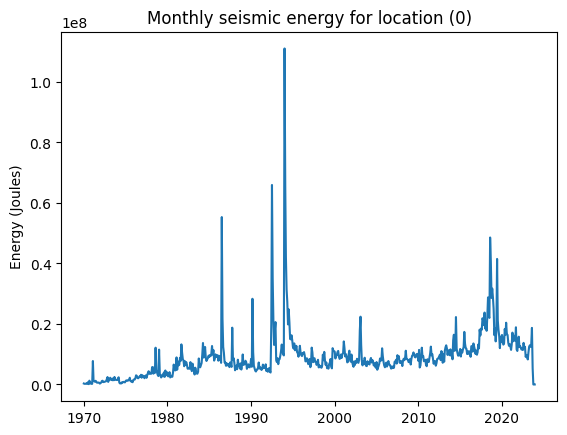

In [471]:
ax0 = sns.lineplot(transposed_df[0])

plt.title("Monthly seismic energy for location (0)")
plt.ylabel("Energy (Joules)")
plt.show()

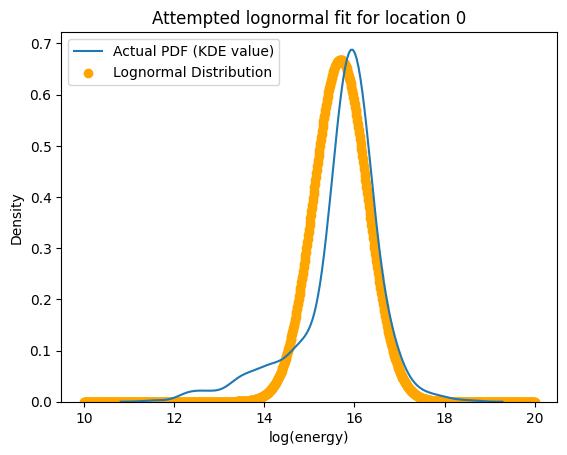

In [472]:
arg1, arg2, arg3 = stats.lognorm.fit(np.log(transposed_df[0][:-3].dropna()))

x = np.linspace(10,20,1000)
y = stats.lognorm.pdf(x, arg1*0.65, arg2, arg3)

ax1 = sns.kdeplot(np.log(transposed_df[0]))
ax2 = plt.scatter(x,y, color='orange')
ax1.legend(['Actual PDF (KDE value)', 'Lognormal Distribution',])
plt.xlabel("log(energy)")
plt.title("Attempted lognormal fit for location 0")
plt.show()

### Location of the 1994 Northridge Earthquake

In this lattice point centered on Northridge, CA, we can easily see the very large and famous 1994 Northridge Earthquake: https://en.wikipedia.org/wiki/1994_Northridge_earthquake 

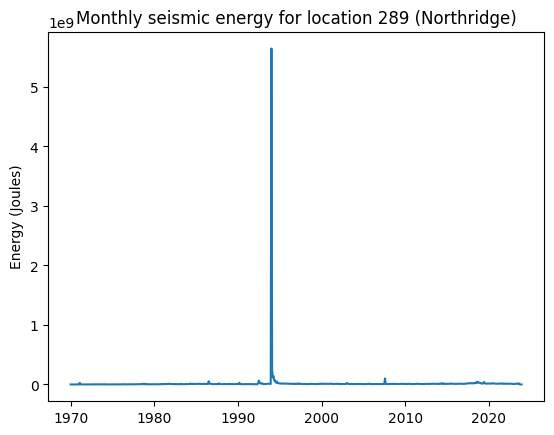

In [473]:
ax0 = sns.lineplot(transposed_df[289])

plt.title("Monthly seismic energy for location 289 (Northridge)")
plt.ylabel('Energy (Joules)')
plt.show()

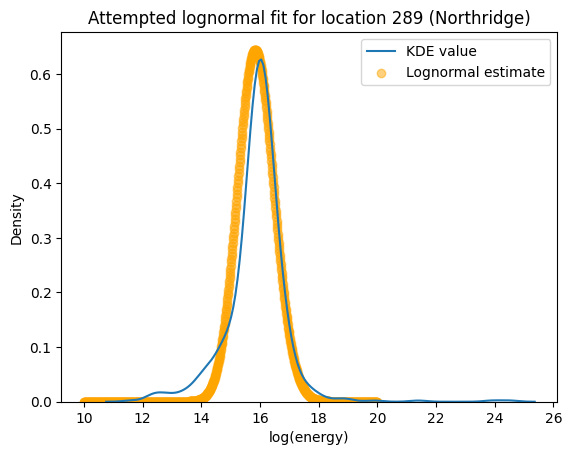

In [474]:
arg1, arg2, arg3 = stats.lognorm.fit(np.log(transposed_df[288][:-3].dropna()))

x = np.linspace(10,20,1000)
y = stats.lognorm.pdf(x, arg1*0.6, arg2, arg3)

ax1 = sns.kdeplot(np.log(transposed_df[288]))
ax2 = plt.scatter(x,y, color='orange', alpha=0.5)
ax1.legend(['KDE value', 'Lognormal estimate',])
plt.xlabel("log(energy)")
plt.title("Attempted lognormal fit for location 289 (Northridge)")
plt.show()

### Location of the 1971 San Fernando Earthquake

San Fernando is located approximately 20 miles from Northridge, and it has its own very large and famous earthquake: https://en.wikipedia.org/wiki/1971_San_Fernando_earthquake

However, even though the Northridge earthquake appears on this chart, the converse is not true: the Northridge chart above does NOT show the 1971 San Fernando quake.

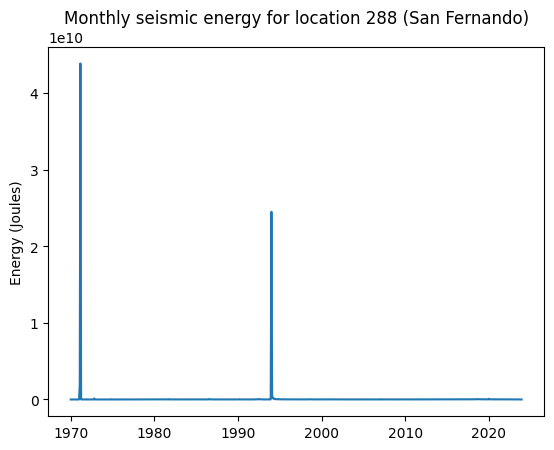

In [475]:
ax0 = sns.lineplot(transposed_df[288])

plt.title("Monthly seismic energy for location 288 (San Fernando)")
plt.ylabel('Energy (Joules)')
plt.show()

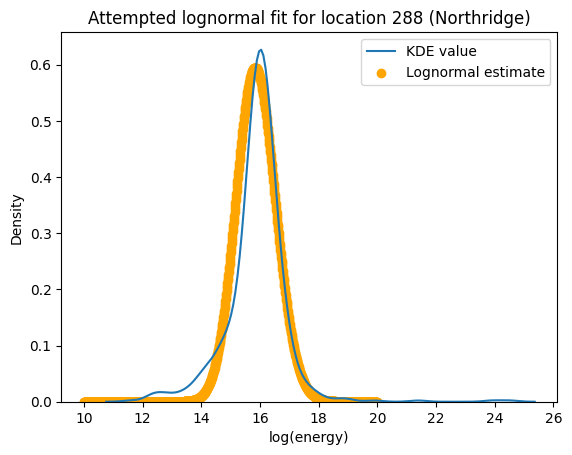

In [476]:
arg1, arg2, arg3 = stats.lognorm.fit(np.log(transposed_df[288][:-3].dropna()))

x = np.linspace(10,20,1000)
y = stats.lognorm.pdf(x, arg1*0.65, arg2, arg3)

ax1 = sns.kdeplot(np.log(transposed_df[288]))
ax2 = plt.scatter(x,y, color='orange')
ax1.legend(['KDE value', 'Lognormal estimate',])
plt.xlabel("log(energy)")
plt.title("Attempted lognormal fit for location 288 (Northridge)")
plt.show()